In [93]:
from query_tracks import * #this script already imports other libraries (i.e., geopandas)
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from datetime import datetime

sns.set_context('paper')

In [104]:
WEB_MERCATOR_EPSG = 3857

def plot_with_labels(gdf, label_column, xlim=None, ylim=None):
    gdf_web = gdf.to_crs(epsg=WEB_MERCATOR_EPSG) #convert to Web Mercator projection so it lines up with the contextily basemap tiles
    ax = gdf_web.plot(figsize=(10, 10), alpha=0.5, edgecolor='darkslateblue')

    # Show BC unit numbers
    gdf_web['center'] = gdf_web.geometry.representative_point()
    centroids = gdf_web.copy()
    centroids.set_geometry('center', inplace = True)
    for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, centroids[label_column]):
        plt.text(x - 6000, y - 6000, label, fontsize = 12)
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
        
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief)
    ax.set_axis_off()
    
    return ax

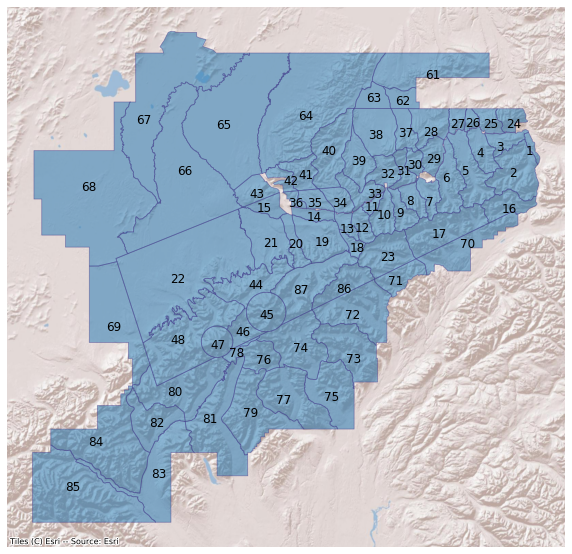

In [105]:
# Get the data for the mask
BC_UNITS_PATH = r"C:\Users\shooper\local_working\overflights_local\sample_data\bc_units.geojson"
bc_units = gpd.read_file(BC_UNITS_PATH)

# Plot it
ax = plot_with_labels(bc_units, 'Unit')

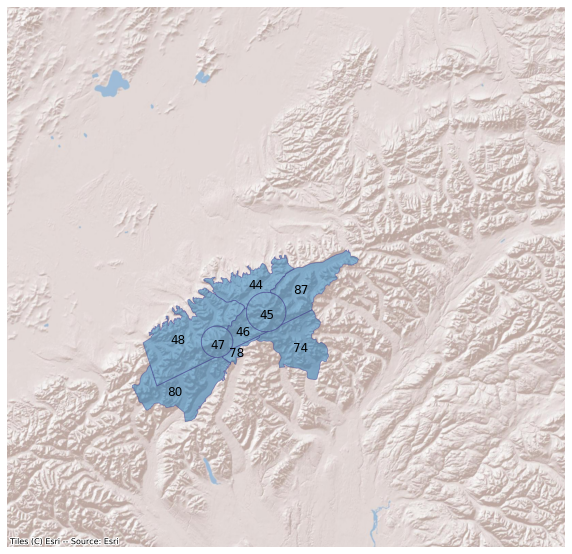

In [106]:
# Get all units that touch Denali and Foraker's units (45 and 47, respectively)
denali_foraker = bc_units.loc[bc_units['Unit'].isin([45, 47])]
mask_units = bc_units.loc[bc_units.geometry.touches(denali_foraker.geometry.unary_union) | bc_units['Unit'].isin([45, 47])]

# Plot the mask
x_axis_range = ax.get_xlim()
y_axis_range = ax.get_ylim()
_ = plot_with_labels(mask_units, 'Unit', xlim=x_axis_range, ylim=y_axis_range)

In [72]:
'''
Show the doc string for the query_tracks script. This describes each parameter. 
If called directly from the command line, the "Usage" string gives the proper syntax,
however, most of the meat is in a function also called "query_tracks." That function 
can be called from another script to integrate its functionality more seamlessly
than the main function, which is intended to be run from the command line.
'''
import query_tracks as qt
print(qt.__doc__)


Query a PostGIS database and either write the results to a file or return in memory as GeoDataFrame.

Usage:
    query_tracks.py <connection_txt> <start_date> <end_date> [--table=<str>] [--start_time=<str>] [--end_time=<str>] [--bbox=<str>] [--mask_file=<str>] [--mask_buffer_distance=<int>] [--clip_output] [--output_path=<str>] [--aircraft_info] [--sql_criteria=<str>]

Examples:

Required parameters:
    connection_txt      Path of a text file containing information to connect to the DB. Each line
                        in the text file must be in the form 'variable_name; variable_value.'
                        Required variables: username, password, ip_address, port, db_name.
    start_date          Earliest date of interest to return data from
    end_date            Latest date of interest to return data from

Options:
    -h, --help                          Show this screen.
    -t, --table=<str>                   Table to query geometries from
    -s, --start_time=<str>        

In [90]:
CONNECTION_TXT = r"C:\Users\shooper\local_working\overflights_local\config_files\connection_info.txt" # db connection parameters

# Create a SQLAlchemy database engine. This isn't a connection to the DB, 
#  but a connection can be established with engine.connect()
engine = db_utils.connect_db(CONNECTION_TXT)

# Get all track points in the database from the beginning of 2019 to now
track_points = query_tracks('2019-1-1', datetime.now().strftime('%Y-%m-%d'), engine=engine, mask=mask_units)

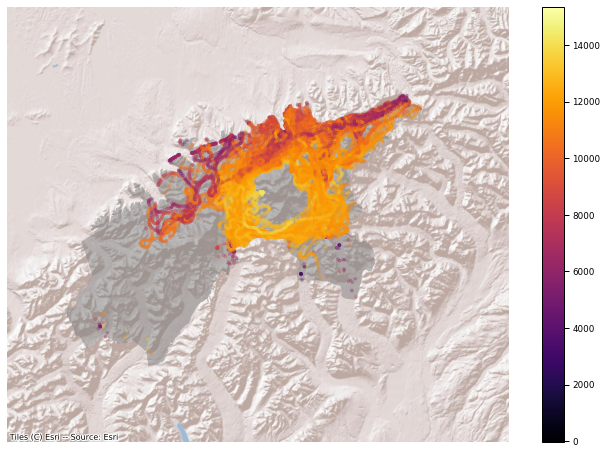

In [92]:
# Show the extent of the mask
ax = gpd.GeoSeries([mask_units.to_crs(epsg=WEB_MERCATOR_EPSG).unary_union]).plot(color='gray', alpha=0.5, figsize=(12, 8))

# Plot the points
track_points_web = track_points.to_crs(epsg=WEB_MERCATOR_EPSG)
track_points_web.plot(column='altitude_ft', 
                      cmap='inferno', 
                      alpha=0.3, 
                      markersize=8,
                      legend=True,
                      ax=ax)

# If the map is too zoomed in, getting the map tiles throws an error. So expand the extent
min_x, min_y, max_x, max_y = track_points_web.geometry.total_bounds
extent_buffer = 50000
ax.set_xlim([min_x - extent_buffer, max_x + extent_buffer])
ax.set_ylim([min_y - extent_buffer, max_y + extent_buffer])

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief)
ax.set_axis_off()